# **Setting Up A Diffusion UNet**

In this NB, we will train an unconditional diffusion model from scratch which will mostly be built using the pipeline components we've already built for this course - in addition to the model specific components from the **Karras Implementation NB i.e. 21_karras_implementation**. 

## **Setup**

In [1]:
import os, timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF, torch.nn.functional as F

from torch.utils.data import DataLoader, default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn, tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8 : fc.defaults.cpus=8

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

## **Load Data**

In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

In [5]:
# Taking the standard deviation of the input data as sigma. Bear in mind that the inplace tfms
# will have an impact on this value.
sig_data = 0.66

In [6]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2))*2-1 for o in b[xl]]

def scalings(sig):
    # Total variance at a particular level of sigma
    totvar = sig**2 + sig_data**2
           #c_skip           , # c_out                   , #c_in
    return sig_data**2/totvar, sig*sig_data/totvar.sqrt(), 1/totvar.sqrt()

def noisify(x0):
    device = x0.device
    # Log normal distribution of sigmas
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1, 1, 1, 1)
    noise = torch.randn_like(x0, device=device)
    # Calculate values to pick an input between a clean image and pure noise
    c_skip, c_out, c_in = scalings(sig)
    noised_input = x0 + noise*sig
    # The target is based on a mixture of both noise and clean images with scaling
    # being done by c_out
    target = (x0 - c_skip*noised_input) / c_out
    # Noised input is scaled up or down using c_in
    return (noised_input*c_in, sig.squeeze()), target

def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds)    : return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

In [7]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [8]:
tds.shape

{'train': (60000, 2), 'test': (10000, 2)}

## **Train Model**

The unconditional model will be trained using the UNet architecture from previous NBs and the **Diffusers** library.

Additionally, we will be using the [SiLU](https://mlarchive.com/machine-learning/activation-functions-all-you-need-to-know/) or the Sigmoid Activation Function.

![title](imgs/SiLU.png)

Using the same convolution as the one from Tiny Imagenet, which is also called the **pre-activation convolution**. 

Preactivation convolution refers to a specific architectural design in NNs where the batch normalization and activation functions are applied before the convolution operation. This approach is primarily associated with enhancing the performance of deep learning models, particularly in residual networks (ResNets).

In [9]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [10]:
# The structure is same as previous ResNet blocks with the exception that there is no option
# for down sampling and strides. That will be featured in the down_block(). This approach is similar
# to the one used in Diffusers.
class UnetResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.convs = nn.Sequential(unet_conv(ni, nf, ks, act=act, norm=norm),
                                   unet_conv(nf, nf, ks, act=act, norm=norm))
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x): return self.convs(x) + self.idconv(x)

By not adding _stride_ and _down-sampling_ to `UnetResBlock()`, we are ensuring that our approach is similar to the one used in the original `DDPM` architecture.

We will try to simplify how different down-sampling blocks can be incorporated into UNets. One way to do this is to introduce the `SavedResBlock()` and `SavedConv()` modules. These two components have similar functionality as ResBlock() and Conv(), but are also able to store the activations. This makes the activations accessible as we develop the model architecture.

In [11]:
class SaveModule:
    # Calls forward to grab the ResBlock and Conv results and stores them.
    def forward(self, x, *args, **kwargs):
        # Using Mixin which contains methods for use by other classes (multiple inheritance)
        # without having to be the parent class of those other classes.
        self.saved = super().forward(x, *args, **kwargs) 
        return self.saved

# These classes only carry out Mixin ops for the target classes.
class SavedResBlock(SaveModule, UnetResBlock): pass # multiple inheritance, First call is used with the second argument 
class SavedConv(SaveModule, nn.Conv2d): pass        # same as above. This allows UnetResBlock and Conv2d outputs to be saved.

In [12]:
def down_block(ni, nf, add_down=True, num_layers=1):
    # SaveModule ops used Sequentially.
    res = nn.Sequential(*[SavedResBlock(ni=ni if i==0 else nf, nf=nf)
                         for i in range(num_layers)])
    # Carry out down sampling if needed.
    if add_down: res.append(SavedConv(nf, nf, 3, stride=2, padding=1))
    return res

In [13]:
# Upsampling will be done with a sequence of upsampling layers - followed by a simple 3x3 conv.
# Again this approach is the one preferred by the Stable Diffusion team.
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [14]:
class UpBlock(nn.Module):
    # Storing previous number of filters (activations and filters stored in prev_nf)
    def __init__(self, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        # Using the saved results in the upsampling path
        self.resnets = nn.ModuleList(
            [UnetResBlock((prev_nf if i==0 else nf) + (ni if (i==num_layers-1) else nf), nf)
             for i in range(num_layers)])
        # Add an upsampling layer if asked.
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, ups):
        # Call each resnet as we progress in the upsampling path. Concatenate downsampling activations with each upsampling
        # layer at the end.
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1)) # Concatenate
        return self.up(x)

The `UNet2dModel` class is pretty similar to our earlier approach. However, we will need to be able to store the activations from the downsampling blocks so that they may be used during upsampling. Also, there is the addition of a `self.mid_block` resblock in the downsampling path.

In [15]:
class UNet2DModel(nn.Module):
    # Setting up input and output channels for RGB images. NFS are the same as the unconditional Stable Diffusion model.
    def __init__(self, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1):
        super().__init__()
        # The create of a larger computational space, using nfs[0] is not particularly efficient.
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        nf = nfs[0]
        self.downs = nn.Sequential()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            # The last down block doesn't have down sampling. Hence the condition.
            self.downs.append(down_block(ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        # Adding an additional resblock during downsampling.
        self.mid_block = UnetResBlock(nfs[-1])
        # Setup the up-sampling path by reversal.
        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        # Final convolution to turn 224 channels to 3 channels.
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d)

    def forward(self, inp):
        # Stores all the layes in `saved`
        x = self.conv_in(inp[0])
        saved = [x]
        # Call sequential model and grab the saved activations.
        x = self.downs(x)
        saved += [p.saved for o in self.downs for p in o]
        x = self.mid_block(x)
        # pop activations from saved blocks.
        for block in self.ups: x = block(x, saved)
        return self.conv_out(x)

In [16]:
# Simplifying the model since we are using fashion MNIST
# For the upsampling block, there will be 3 layers since the UNet2DModel has -->
# self.ups.append(UpBlock(ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
# This aligns with Diffusers and ends up saving the output of the downsampling.
model = UNet2DModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2)

In [18]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [19]:
learn.fit(epochs) # Pending migration to Colab.

This model leaves the **Time Embedding** and **Attention** modules. Lets work towards now.

## **Building Upto A Time Step Model**

We will work towards building a resblock with embeddings where `forward()` not only results in activations, but also in an additional parameter `t`. `t` is a vector which represents the embeddings of each time step aka temporal steps. These embeddings are similar to ones in NLP. Here each timestep will have its own vector representation. This idea applies to both discrete and continuous time steps _(Karras et al. used continuous sigmas)_. It should also be noted that two sigmas with similar values should have the same embeddings.

### **A Note On (Sinusoidal) Time Steps / Time Embeddings**

In [45]:
emb_dim = 16 # Embedding dimension size
tsteps = torch.linspace(-10, 10, 100) # Timesteps though we won't have negative sigmas in practice.
max_period = 10000 # Largest timestep. Also aligns with the max sequence length chosen by researchers

In [21]:
math.log(10000)

9.210340371976184

In [46]:
# The exponent will have 8 embeddings instead of 16
exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)

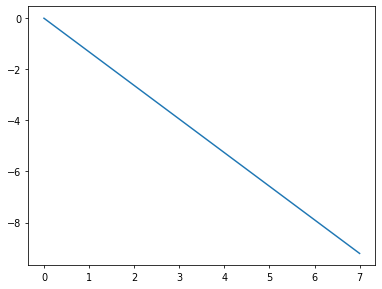

In [23]:
plt.plot(exponent);

In [47]:
# Outer product of exponent and time steps.
emb = tsteps[:, None].float() * exponent.exp()[None, :]
emb.shape

torch.Size([100, 8])

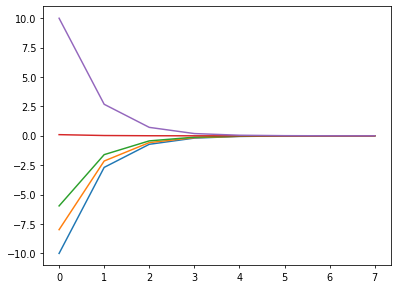

In [35]:
plt.plot(emb[0])
plt.plot(emb[10])
plt.plot(emb[20])
plt.plot(emb[50])
plt.plot(emb[-1]);

In [36]:
# Sine waves across 100 sigmas
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
emb.shape

torch.Size([100, 16])

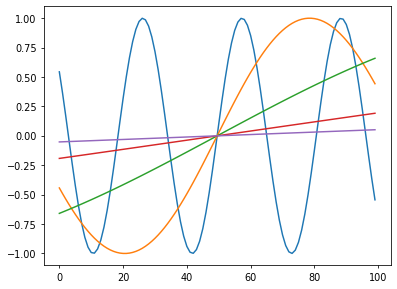

In [37]:
plt.plot(emb[:, 0])
plt.plot(emb[:, 1])
plt.plot(emb[:, 2])
plt.plot(emb[:, 3])
plt.plot(emb[:, 4]);

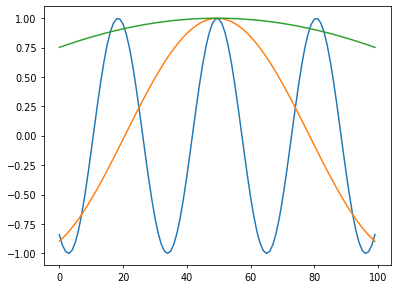

In [38]:
plt.plot(emb[:, 8])
plt.plot(emb[:, 9])
plt.plot(emb[:, 10]);

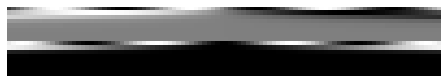

In [39]:
# Concatenated embeddings represented across columns in the image below.
show_image(emb.T, figsize=(8, 8));

In [48]:
# Formalizing into a single function.
def timestep_embedding(tsteps, emb_dim, max_period=10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:, None].float() * exponent.exp()[None, :]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0, 1, 0, 0)) if emb_dim%2==1 else emb

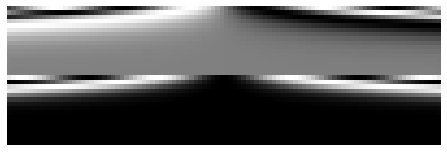

In [50]:
show_image(timestep_embedding(tsteps, 32, max_period=1000).T, figsize=(8, 8));

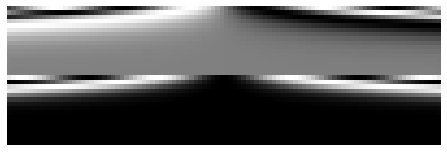

In [43]:
show_image(timestep_embedding(tsteps, 32, max_period=1000).T, figsize=(8, 8));

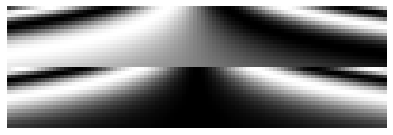

In [44]:
show_image(timestep_embedding(tsteps, 32, max_period=10).T, figsize=(7,7));

Based on the plots and how embedding spaces are utilized across different dimensions and max periods in particular, it becomes clear that the usage of `max_period=10000` is sub-optimal.

### **Time Step Model**

Lets build and train a UNet with the addition of timestep embeddings.

In [51]:
from functools import wraps

In [52]:
??wraps

Signature:
wraps(
    wrapped,
    assigned=('__module__', '__name__', '__qualname__', '__doc__', '__annotations__'),
    updated=('__dict__',),
)
Source:   
def wraps(wrapped,
          assigned = WRAPPER_ASSIGNMENTS,
          updated = WRAPPER_UPDATES):
    """Decorator factory to apply update_wrapper() to a wrapper function

       Returns a decorator that invokes update_wrapper() with the decorated
       function as the wrapper argument and the arguments to wraps() as the
       remaining arguments. Default arguments are as for update_wrapper().
       This is a convenience function to simplify applying partial() to
       update_wrapper().
    """
    return partial(update_wrapper, wrapped=wrapped,
                   assigned=assigned, updated=updated)
File:      ~/miniforge3/envs/miniai/lib/python3.11/functools.py
Type:      function

In [53]:
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

In [59]:
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = unet_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = unet_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale, shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        return x + self.idconv(inp)

In [54]:
def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

In [55]:
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

In [56]:
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf) + (ni if (i==num_layers-1) else nf), nf)
             for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

In [57]:
class EmbUNetModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x, t = inp
        temb = timestep_embeddings(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [60]:
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2)

In [63]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)